In [2]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import json
import math
import copy
import random
from collections import defaultdict, Counter, OrderedDict
from itertools import combinations
import unicodedata
import re
import matplotlib.pyplot as plt
import pickle

In [3]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
import wikipedia as wiki
import Levenshtein as lvst
from metaphone import doublemetaphone as dmt_phone
import networkx as nx
import nxviz as nv
from sparse_dot_topn import awesome_cossim_topn as cossim_topn

In [6]:
import spacy
from spacy import displacy
from spacy.symbols import nsubj, VERB, NOUN
from spacy.tokens import Doc, Token, Span
from spacy.attrs import ENT_IOB, ENT_TYPE
from spacy.tokenizer import Tokenizer

In [159]:
df=pd.read_excel("corpus/Discovery_entity_ver_4.xlsx")

In [14]:
persons= df["Dis_Person"]

In [15]:
persons

0             Michael Jordan
1              Magic Johnson
2               LeBron James
3            Hakeem Olajuwon
4        Kareem Abdul-Jabbar
                ...         
27546             Gary Davis
27547             Doug Finke
27548            Zoya Akhtar
27549     Arundhuti Banerjee
27550         редактор сайта
Name: Dis_Person, Length: 27551, dtype: object

# Methodology
In this section, I explore several approaches to normalize entity names. Experiments is being done for *Person names*.

- **Matching Algorithms** (Ensemble or Hierarchical)
    - String simiarity: Levenshtein distance, Jaro-Winkler distance
    - Normalizing to ASCII (for non-english character-encoded names)
    - Removing special characters and white spaces
    - Doublemetaphone matching
    - Word sorting by first letters of chunk (for example, William Telle &rarr; Telle William)
    - Subword-level TF-IDF expansion and consine-simliarity
    - Abbreviation/Acronym matching by Wikipedia data investigation and linking
    - Expanding to normal words (e.g. Stephen W. Hawking &rarr; Stephen Willam Hawking) - need to investigate HOW to

- **Use ensemble method**
    - Apply different weight schemes for different entity-types

- **Find normalzed form of names**
    - detect connected components
    - use distance-median, etc.
    

In [8]:
prefixes1 = ['Mr.', 'Mrs.', 'Ms.', 'Miss', 'Dr.', 'Sir', 'Sir.', "Ma'am", 'Maddam']
prefixes2 = ['President', 'Gen.', 'Prime Minister', 'Director', 'Deputy Director', 'Army Gen.'
            , 'General',  'Secretary', 'Treasury Secretary', 'Major General', 'Major Gen.'
            , 'Colonel', 'Lieutenant Colonel', 'LTG', 'Minister', 'Ambassador', 'Premier'
            , 'Management MG', 'MG', 'Lieutenant General', 'Defence Minister', 'Admiral'
            , 'General Manager', 'Party Secretary', 'Speaker', 'Defense Minister'
            , 'Defence Secretary', 'Defense Secretary', 'Marshall', 'Vice President'
            ]
prefixes1_lower = [p.lower() for p in prefixes1]
prefixes2_lower = [p.lower() for p in prefixes2]

prefixes_all = prefixes1 + prefixes2 + prefixes1_lower + prefixes2_lower

for pf in prefixes_all:
    if pf[-1] == '.':
        prefixes_all.append(pf[:-1])
        
for pf in prefixes_all:
    if len(pf.split()) > 1:
        prefixes_all.extend(pf.split())

prefixes_all = list(set(prefixes_all))
prefixes_all.sort(key=len, reverse=True)

               
print(prefixes_all)

['lieutenant general', 'Treasury Secretary', 'treasury secretary', 'lieutenant colonel', 'Lieutenant Colonel', 'Lieutenant General', 'defence secretary', 'Defence Secretary', 'defense secretary', 'Defense Secretary', 'defence minister', 'Defence Minister', 'Defense Minister', 'defense minister', 'Deputy Director', 'general manager', 'party secretary', 'deputy director', 'Party Secretary', 'General Manager', 'vice president', 'Prime Minister', 'prime minister', 'Vice President', 'Major General', 'Management MG', 'major general', 'management mg', 'Lieutenant', 'management', 'lieutenant', 'major gen.', 'Management', 'Major Gen.', 'Ambassador', 'ambassador', 'Secretary', 'president', 'secretary', 'major gen', 'Army Gen.', 'Major Gen', 'army gen.', 'President', 'minister', 'director', 'army gen', 'Marshall', 'Minister', 'Director', 'marshall', 'treasury', 'Army Gen', 'Treasury', 'speaker', 'defense', 'Premier', 'Speaker', 'Colonel', 'defence', 'Defense', 'colonel', 'general', 'admiral', 'De

In [9]:
def generate_ngrams(data, n=3, captialized_1st=True, prefix2remove=prefixes_all):
    '''
    generate subword-level ngrams
    '''
    # dealing non-ASCII characters
    normal = unicodedata.normalize('NFKD', data).encode('ASCII', 'ignore')
    val = normal.decode("utf-8") # no lovercasing yet
    
    # remove prefix
    if prefix2remove:  
        for prefix in prefix2remove:
            val = val.replace(prefix, '')
            #val = val[1:] if val[0] == ' ' else val # remove any starting white space
    
    # lowercasing
    val = val.lower()
    # remove special characters
    val = re.sub('[^A-Za-z0-9 ]+', ' ', val)
    # remove multiple spaces
    val = re.sub(' +', ' ', val)
    
    #print(val)
    
    # Capitalized 1st letter of every word
    if captialized_1st: 
        val = val.title()
    # padding
    padding = ' '
    val = padding + val + padding
    #string = re.sub(r'[,-./]|\sBD',r'', string)
    
    ngrams = zip(*[val[i:] for i in range(n)])
    
    return [''.join(ngram) for ngram in ngrams]

In [11]:
print(generate_ngrams('Prime Minister Churchill'))

['  C', ' Ch', 'Chu', 'hur', 'urc', 'rch', 'chi', 'hil', 'ill', 'll ']


In [16]:
vectorizer = TfidfVectorizer(min_df=1, analyzer=generate_ngrams)
tf_idf_matrix = vectorizer.fit_transform(persons)

In [17]:
tf_idf_matrix.shape

(27551, 11288)

In [18]:
similarity_matrix = cossim_topn(tf_idf_matrix, tf_idf_matrix.transpose(), 2, 0.01, use_threads=True, n_jobs=4)

In [19]:
def get_matches_df(similarity_matrix, A, B):
        '''
        Takes a matrix with similarity scores and two arrays, A and B,
        as an input and returns the matches with the score as a dataframe.
        Args:
            similarity_matrix (csr_matrix)  : The matrix (dimensions: len(A)*len(B)) with the similarity scores
            A              (pandas.Series)  : The array to be matched (dirty)
            B              (pandas.Series)  : The baseline array (clean)
        Returns:
            pandas.Dataframe : Array with matches between A and B plus scores
        '''
        non_zeros = similarity_matrix.nonzero()

        sparserows = non_zeros[0]
        sparsecols = non_zeros[1]

        nr_matches = sparsecols.size

        in_text = np.empty([nr_matches], dtype=object)
        matched = np.empty([nr_matches], dtype=object)
        similarity = np.zeros(nr_matches)

        in_text = np.array(A)[sparserows]
        matched = np.array(B)[sparsecols]
        similarity = np.array(similarity_matrix.data)

        df_tuples = list(zip(in_text, matched, similarity))

        return pd.DataFrame(df_tuples, columns=['in_text', 'matched', 'similarity'])

In [20]:
res = get_matches_df(similarity_matrix, pd.Series(persons), pd.Series(persons))

In [21]:
res.head(20)

,in_text,matched,similarity
0,Michael Jordan,Michael Jordan,1.000000
1,Michael Jordan,Jordan,0.682902
2,Magic Johnson,Magic Johnson,1.000000
3,Magic Johnson,Johnson,0.569778
4,LeBron James,LeBron James,1.000000
5,LeBron James,LeBron,0.786869
6,Hakeem Olajuwon,Hakeem Olajuwon,1.000000
7,Hakeem Olajuwon,Rep. Hakeem Jeffries,0.338072
8,Kareem Abdul-Jabbar,Kareem Abdul-Jabbar,1.000000
9,Kareem Abdul-Jabbar,Kareem Abdu-Jabbar,0.832282


In [22]:
res.shape

(55080, 3)

In [23]:
threshold = 0.7 # need to be adjusted, the higer the thershold, the higher accuracy and the lower coverage
res2 = res[(res.similarity > threshold) & (res.in_text != res.matched)]
res2.shape

(8677, 3)

In [24]:
res2.head(20)

,in_text,matched,similarity
5,LeBron James,LeBron,0.786869
9,Kareem Abdul-Jabbar,Kareem Abdu-Jabbar,0.832282
15,Wilt Chamberlain,Chamberlain,0.808299
17,Larry Bird,bird,0.717489
19,Bill Russel,Russell,0.737064
35,Muhammad Ali,Muhammad,0.850303
43,Gov. Greg Abbott,Gov. Gregg Abbott,0.888608
71,Karl Malone,Malone,0.727620
73,Luis Castillo,Castillo,0.765102
79,Tommy,Tommy Davis,0.733941


In [25]:
def remove_duplicated_match(df, col1='in_text', col2='matched'):
    '''
    generate a temporary column of "pair" and use it for de-duping and remove it
    '''
    temp = list()
    names1 = df[col1].tolist()
    names2 = df[col2].tolist()
    for tp in zip(names1, names2):
        temp.append(str(sorted(list(tp))))
    
    df['pair'] = temp
    df.drop_duplicates(subset="pair", inplace=True)
    df.drop(columns=['pair'], axis=1, inplace=True)
    
    return df

In [34]:
def get_simliar_names_by_tfdif(names, topN=2, threshold=0.7, remove_selfMatch=True, verbose=0):
    '''
    To Do: function description
    '''
    # get subword-level tf-idf features for each names
    vectorizer = TfidfVectorizer(min_df=1, analyzer=generate_ngrams)
    tf_idf_mat = vectorizer.fit_transform(names)
    if verbose:
        print('tf_idf_mat size: {}'.format(tf_idf_mat.shape))
    
    # get top N simliar names by consine simliarity
    similarity_mat = cossim_topn(tf_idf_mat, tf_idf_mat.transpose(),
                                 topN, use_threads=True, n_jobs=4)
    
    # get dataframe of matched result
    df_matched = get_matches_df(similarity_mat, pd.Series(names), pd.Series(names))
    if verbose:
        print('df_matched_raw size: {}'.format(df_matched.shape))
    
    # filter by simliarity threshold and remove self-matching
    df_matched = df_matched[(df_matched.similarity > threshold)]
    
    # remove self-matching:
    if remove_selfMatch:
        df_matched = df_matched[(df_matched.in_text != df_matched.matched)]
    
    # retain only one copy of matched pairs
    #df_matched.drop_duplicates(subset="similarity", inplace=True)
    df_matched = remove_duplicated_match(df_matched)
    
    # reverse sort by simliarty
    df_matched.sort_values(by=['similarity'], ascending=False, inplace=True)
    
    if verbose:
        print('df_matched_final size: {}'.format(df_matched.shape))
    
    return df_matched 

In [35]:
df_test = get_simliar_names_by_tfdif(persons, threshold=0.7)
df_test.head(20)

,in_text,matched,similarity
24875,Rev Al Sharpton,Rev. Al Sharpton,1.0
31051,Prime Minister Boris Johnson,Minister Boris Johnson,1.0
13059,Baker Mayfield,baker mayfield,1.0
5337,John F Kennedy,John F. Kennedy,1.0
34070,Dr. Jennifer,Ms. Jennifer,1.0
4783,Sen. **Charles Grassley,Sen. Charles Grassley,1.0
2585,Prime Minister Najib Razak,Minister Najib Razak,1.0
5069,Gonzalez,GONZALEZ,1.0
6345,jr.,Jr.,1.0
7843,Sean,sean,1.0


In [36]:
df_test.shape

(6208, 3)

## First Letter Match

In [37]:
prefixes_all

['lieutenant general',
 'Treasury Secretary',
 'treasury secretary',
 'lieutenant colonel',
 'Lieutenant Colonel',
 'Lieutenant General',
 'defence secretary',
 'Defence Secretary',
 'defense secretary',
 'Defense Secretary',
 'defence minister',
 'Defence Minister',
 'Defense Minister',
 'defense minister',
 'Deputy Director',
 'general manager',
 'party secretary',
 'deputy director',
 'Party Secretary',
 'General Manager',
 'vice president',
 'Prime Minister',
 'prime minister',
 'Vice President',
 'Major General',
 'Management MG',
 'major general',
 'management mg',
 'Lieutenant',
 'management',
 'lieutenant',
 'major gen.',
 'Management',
 'Major Gen.',
 'Ambassador',
 'ambassador',
 'Secretary',
 'president',
 'secretary',
 'major gen',
 'Army Gen.',
 'Major Gen',
 'army gen.',
 'President',
 'minister',
 'director',
 'army gen',
 'Marshall',
 'Minister',
 'Director',
 'marshall',
 'treasury',
 'Army Gen',
 'Treasury',
 'speaker',
 'defense',
 'Premier',
 'Speaker',
 'Colonel',


In [40]:
def normalize_unicode_to_ascii(data, lowercasing=True):
    normal = unicodedata.normalize('NFKD', data).encode('ASCII', 'ignore')
    val = normal.decode("utf-8")
    if lowercasing:
        val = val.lower()
    # remove special characters
    val = re.sub('[^A-Za-z0-9 ]+', ' ', val)
    # remove multiple spaces
    val = re.sub(' +', ' ', val)
    return val

In [41]:
def first_letters(word, sorting=False, prefix2remove=prefixes_all):
    if prefix2remove:  
        for prefix in prefix2remove:
            word = word.replace(prefix, '')
        #word = word[1:] if word[0] == ' ' else word # remove any starting white space
    #print(word)
    val = normalize_unicode_to_ascii(word, lowercasing=False)      
    parts = val if val.isupper() and ' ' not in val else val.split() # don't split if val itself is an acronym
    
    res = [p[0].lower() for p in parts]
    if sorting:
        res.sort()
    
    return "".join(res)

In [42]:
first_letters("Gen Yuri Baluyevskiy", sorting=True)

'by'

In [43]:
first_letters("Major General Qiao Liang")

'ql'

In [44]:
def get_1st_letters_match(A_iter, B_iter, sorting=False, partial_match=False, prefix2remove=prefixes_all):
    '''
    param:
        A_iter, B_iter: iterable with same length
    return:
        list of boolean values
    '''
    assert len(A_iter) == len(B_iter)
    
    res = list()
    for tp in zip(A_iter, B_iter):
        first_letters_A = first_letters(tp[0]
                                        , sorting=sorting
                                        , prefix2remove=prefix2remove
                                       )
        
        first_letters_B = first_letters(tp[1]
                                        , sorting=sorting
                                        , prefix2remove=prefix2remove
                                       )

        if len(first_letters_B) < len(first_letters_A):
            first_letters_A, first_letters_B = first_letters_B, first_letters_A
        
        #print(first_letters_A)
        #print(first_letters_B)
        
        if partial_match:
            if first_letters_A in first_letters_B:
                res.append(True)
            else:
                res.append(False)
        else:
            if first_letters_A == first_letters_B:
                res.append(True)
            else:
                res.append(False)
    
    return res

In [45]:
get_1st_letters_match(["President Ezer Weizman"],["Ezer Weizman"], sorting=True, partial_match=True)

[True]

In [46]:
first_letter_match = get_1st_letters_match(df_test.in_text, df_test.matched, sorting=True)
df_test["first_letter_match"] = first_letter_match

In [48]:
df_test.head(10)

,in_text,matched,similarity,first_letter_match
24875,Rev Al Sharpton,Rev. Al Sharpton,1.0,True
31051,Prime Minister Boris Johnson,Minister Boris Johnson,1.0,True
13059,Baker Mayfield,baker mayfield,1.0,True
5337,John F Kennedy,John F. Kennedy,1.0,True
34070,Dr. Jennifer,Ms. Jennifer,1.0,True
4783,Sen. **Charles Grassley,Sen. Charles Grassley,1.0,True
2585,Prime Minister Najib Razak,Minister Najib Razak,1.0,True
5069,Gonzalez,GONZALEZ,1.0,False
6345,jr.,Jr.,1.0,True
7843,Sean,sean,1.0,True


In [49]:
# Double Metaphone

In [50]:
def match_doublemetaphone(word_pair, normalize2Ascii=True, prefix2remove=prefixes_all):
    '''
    ToDo: function description
    '''
    w1, w2 = word_pair
    
    if prefix2remove:  
        for prefix in prefix2remove:
            w1 = w1.replace(prefix, '')
            w2 = w2.replace(prefix, '')
    
        # remove any starting white space
        #w1 = w1[1:] if w1[0] == ' ' else w1
        #w2 = w2[1:] if w2[0] == ' ' else w2
    
    match_types = ['ASCII_norm_match', 'strong_match', 'weak_match', 'minimal_match', 'no_match']
    
    if normalize2Ascii:
        w1, w2 = tuple(map(normalize_unicode_to_ascii, (w1, w2)))
        if w1 == w2:
            return (True, match_types[0], (None, None))
    else:
        w1, w2 = word_pair
    
    tp1 = dmt_phone(w1)
    tp2 = dmt_phone(w2)
    
    match = True
    if tp1[0] == tp2[0]: # primary_key match
        match_type = match_types[1]
    elif tp1[0] == tp2[1] or tp1[1] == tp2[0]: # secondary_key == primary_key or vise versa
        match_type = match_types[2]
    elif tp[1] == tp2[1]: # secondary_key == secondary_key
        match_type = match_types[3]
    else:
        match, match_type = False, match_types[4]
    
    return (match, match_type, (tp1, tp2))

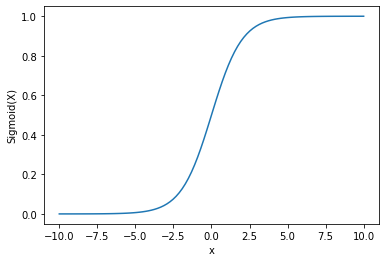

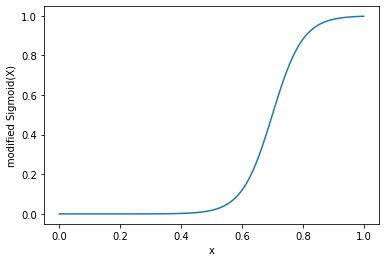

In [51]:
def sigmoid(x, a=1):
    return 1/(1 + np.exp(-a*x))

x = np.linspace(-10, 10, 100) 
z = sigmoid(x) 
  
plt.plot(x, z) 
plt.xlabel("x") 
plt.ylabel("Sigmoid(X)") 
  
plt.show() 

x = np.linspace(0, 1, 100) 
z = sigmoid(20*x-14) 
  
plt.plot(x, z) 
plt.xlabel("x") 
plt.ylabel("modified Sigmoid(X)") 
  
plt.show() 

In [52]:
def dmtph_match_score(x):
    '''
    This function gives rewards for "ascii_norm_match" & "strong_match", but penalties for the rest
    i.e. non-linear weighting
    '''
    return sigmoid(20*(x-0.7))

x = np.linspace(0, 1, 5)
print(x)
print(dmtph_match_score(x))

[0.   0.25 0.5  0.75 1.  ]
[8.31528028e-07 1.23394576e-04 1.79862100e-02 7.31058579e-01
 9.97527377e-01]


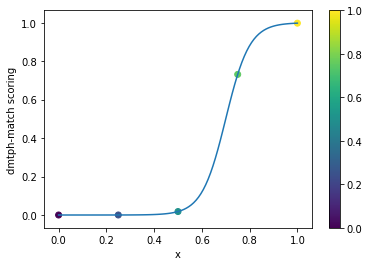

In [53]:
x = np.linspace(0, 1, 100) 
x2 = np.linspace(0, 1, 5)
 
plt.plot(x, dmtph_match_score(x)) 
plt.scatter(x2, dmtph_match_score(x2), c=x2, cmap='viridis')
plt.xlabel("x") 
plt.ylabel("dmtph-match scoring") 
plt.colorbar()  
plt.show() 

In [72]:
def match_doublemetaphone(word_pair,prefix2remove, normalize2Ascii=True, remove_prefix=True):
    '''
    ToDo: function description
    '''
    w1, w2 = word_pair
    
    prefixes = prefix2remove
    if remove_prefix:  
        for prefix in prefixes:
            w1 = w1.replace(prefix, '')
            w2 = w2.replace(prefix, '')
    
    match_types = ['ASCII_norm_match', 'strong_match', 'weak_match', 'minimal_match', 'no_match']
    
    if normalize2Ascii:
        w1, w2 = tuple(map(normalize_unicode_to_ascii, (w1, w2)))
        if w1 == w2:
            return (True, match_types[0], (None, None))
    else:
        w1, w2 = word_pair
    
    tp1 = dmt_phone(w1)
    tp2 = dmt_phone(w2)
    
    match = True
    if tp1[0] == tp2[0]: # primary_key match
        match_type = match_types[1]
    elif tp1[0] == tp2[1] or tp1[1] == tp2[0]: # secondary_key == primary_key or vise versa
        match_type = match_types[2]
    elif tp1[1] == tp2[1]: # secondary_key == secondary_key
        match_type = match_types[3]
    else:
        match, match_type = False, match_types[4]
    
    return (match, match_type, (tp1, tp2))

In [73]:
def doublemetaphone_simliarity(entity_list):
    match_types = ['ASCII_norm_match', 'strong_match', 'weak_match', 'minimal_match', 'no_match']
    
    # mutually exclusive match groups
    ascii_norm_match = list()
    strong_match = list()
    weak_match = list()
    minimal_match = list()
    
    for name_tp in combinations(entity_list, 2):
        matched, match_type, double_metaphones = match_doublemetaphone(name_tp)
        if matched:
            if match_type == match_types[0]:
                ascii_norm_match.append(name_tp)
            elif match_type == match_types[1]:
                strong_match.append(name_tp)
            elif match_type == match_types[2]:
                weak_match.append(name_tp)
            elif match_type == match_types[3]:
                minimal_match.append(name_tp)
    
    return ascii_norm_match, strong_match, weak_match, minimal_match    

In [74]:
def get_dmtph_match(A_iter, B_iter, prefix2remove=prefixes_all):
    '''
    param:
        A_iter, B_iter: iterable with same length
    return:
        list of match scores
    '''
    assert len(A_iter) == len(B_iter)
    
    match_types = ['ASCII_norm_match', 'strong_match', 'weak_match', 'minimal_match', 'no_match']
    match_types.reverse()
    x = np.linspace(0, 1, 5)

    res = list()
    for tp in zip(A_iter, B_iter):
        match, match_type, dummy = match_doublemetaphone(tp, prefix2remove=prefix2remove)
        match_score = dmtph_match_score(x[match_types.index(match_type)])
        res.append(match_score)
    
    return res

In [75]:
dmtph_match = get_dmtph_match(df_test.in_text, df_test.matched)

In [76]:
df_test["dmtph_match"] = dmtph_match

In [77]:
df_test.head()

,in_text,matched,similarity,first_letter_match,dmtph_match
24875,Rev Al Sharpton,Rev. Al Sharpton,1.0,True,0.997527
31051,Prime Minister Boris Johnson,Minister Boris Johnson,1.0,True,0.997527
13059,Baker Mayfield,baker mayfield,1.0,True,0.997527
5337,John F Kennedy,John F. Kennedy,1.0,True,0.997527
34070,Dr. Jennifer,Ms. Jennifer,1.0,True,0.997527


In [78]:
def get_string_distance(A_iter, B_iter, normalize=True, prefix2remove=prefixes_all):
    '''
    param:
        A_iter, B_iter: iterable with same length
    return:
        lists of invese-Levenshtein distance & Jaro-Winkler distance, respectively 
    '''
    assert len(A_iter) == len(B_iter)
    
    res_inv_lvst = list()
    res_jw = list()
    for w1, w2 in zip(A_iter, B_iter):
        if prefix2remove:  
            for prefix in prefix2remove:
                w1 = w1.replace(prefix, '')
                w2 = w2.replace(prefix, '')
        
            # remove any starting white space
            #w1 = w1[1:] if w1[0] == ' ' else w1
            #w2 = w2[1:] if w2[0] == ' ' else w2
        
        if normalize:
            w1, w2 = tuple(map(normalize_unicode_to_ascii, (w1, w2)))
        else:
            pass
        
        inv_lvst_dist = 1/lvst.distance(w1, w2) if lvst.distance(w1, w2) else 1 # avoid dividing by zero
        jw_dist = lvst.jaro_winkler(w1, w2)
        res_inv_lvst.append(inv_lvst_dist)
        res_jw.append(jw_dist)
    
    return res_inv_lvst, res_jw

In [79]:
inv_lvst_dist, jw_dist = get_string_distance(df_test.in_text, df_test.matched)

In [80]:
df_test["inv_lvst_dist"] = inv_lvst_dist
df_test["jw_dist"] = jw_dist

In [83]:
df_test.tail(20)

,in_text,matched,similarity,first_letter_match,dmtph_match,inv_lvst_dist,jw_dist
6931,Elaine Collins,Elaine,0.700302,False,1.233946e-04,0.125000,0.923810
23281,Molino,Moline,0.700301,True,7.310586e-01,1.000000,0.944444
1165,Duke Dawson,Dawson,0.700301,False,1.233946e-04,0.200000,0.477273
23555,Lori Jackson,Jackson,0.700239,False,8.315280e-07,0.200000,0.408730
6943,Kincaid,Anna Kincaid-Cline,0.700233,False,1.233946e-04,0.090909,0.420635
1755,Arla,Arlanda,0.700225,True,1.233946e-04,0.333333,0.914286
46003,Katie Beck,Katie,0.700223,False,1.233946e-04,0.200000,0.916667
34368,Raymond Mercado,mercado,0.700212,False,1.233946e-04,0.125000,0.515873
47023,Calvin Nolan,Calvin,0.700201,False,1.233946e-04,0.166667,0.933333
53429,Christopher Fleming,Christopher,0.700148,False,1.233946e-04,0.125000,1.000000


In [85]:
# Wrapper

In [87]:
def get_df_match(entity_names, entity_type, entity_subtypes=[]
                 , wiki_match=False
                 , prefix2remove=prefixes_all
                 , sorting_1st_letters=False
                 , partial_1st_letter_match=False
                 , co_doc_by_file=True       
                ):
    
    df = get_simliar_names_by_tfdif(entity_names)
    
    print("# of candidate pairs: {}".format(df.shape[0]))
    if wiki_match:
        df["wiki_match"] = get_wiki_match(df.in_text, df.matched)
    
    df["first_letter_match"] = get_1st_letters_match(df.in_text, df.matched
                                                     , sorting=sorting_1st_letters
                                                     , partial_match=partial_1st_letter_match
                                                     , prefix2remove=prefix2remove
                                                    )
    
#     df["co_doc_ratio"] = get_co_document_ratio(df.in_text, df.matched
#                                                , entity_type=entity_type
#                                                , entity_subtypes=entity_subtypes
#                                                , by_file=co_doc_by_file      
#                                               )
    
    df["dmtph_match"] = get_dmtph_match(df.in_text, df.matched, prefix2remove=prefix2remove)
    
    inv_lvst_dist, jw_dist = get_string_distance(df.in_text, df.matched, prefix2remove=prefix2remove)
    df["inv_lvst_dist"] = inv_lvst_dist
    df["jw_sim"] = jw_dist # in python Levenshtein library, this is actually simlarity ranging [0, 1]
    
    return df

In [88]:
df_test = get_df_match(persons, 'Person', sorting_1st_letters=True, partial_1st_letter_match=True)

# of candidate pairs: 6208


In [89]:
df_test.head()

,in_text,matched,similarity,first_letter_match,dmtph_match,inv_lvst_dist,jw_sim
24875,Rev Al Sharpton,Rev. Al Sharpton,1.0,True,0.997527,1.0,1.0
31051,Prime Minister Boris Johnson,Minister Boris Johnson,1.0,True,0.997527,1.0,1.0
13059,Baker Mayfield,baker mayfield,1.0,True,0.997527,1.0,1.0
5337,John F Kennedy,John F. Kennedy,1.0,True,0.997527,1.0,1.0
34070,Dr. Jennifer,Ms. Jennifer,1.0,True,0.997527,1.0,1.0


### Weighted average of matchings

In [90]:
def get_ensemble_match(df, weights=[]):
    '''
    get a weighted average of matching scores
    '''
    row_num = df.shape[0]
    matchings = df.columns[2:]
    if weights:
        assert len(weights) == len(matchings)
        weights = np.array(weights)
    else:
        weights = np.ones(len(matchings))
    
    match_score = pd.Series(np.zeros(row_num), dtype='float64')
    for weight, matching in zip(weights, matchings):
        match_score += weight*df[matching]
    
    match_score = match_score/weights.sum()
    
    return match_score

In [91]:
def add_match_score(df, weights=[]):
    if 'match_score' in df.columns:
        df.drop(['match_score'], axis=1, inplace=True)
    df['match_score'] = get_ensemble_match(df, weights=weights)
    df.sort_values(by='match_score', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)

In [92]:
weights_person = [4,2,1,1,1]
add_match_score(df_test, weights=weights_person)

In [95]:
df_test.head(50)

,in_text,matched,similarity,first_letter_match,dmtph_match,inv_lvst_dist,jw_sim,match_score
0,John F Kennedy,John F. Kennedy,1.0,True,0.997527,1.0,1.0,0.999725
1,Sen. **Charles Grassley,Sen. Charles Grassley,1.0,True,0.997527,1.0,1.0,0.999725
2,Пользователей сайта,редактор сайта,1.0,True,0.997527,1.0,1.0,0.999725
3,регистрации Эл,редактор сайта,1.0,True,0.997527,1.0,1.0,0.999725
4,JESSE,Jesse,1.0,True,0.997527,1.0,1.0,0.999725
5,PATRICK,Patrick,1.0,True,0.997527,1.0,1.0,0.999725
6,Abby,ABBY,1.0,True,0.997527,1.0,1.0,0.999725
7,регистрации Эл,Россию на,1.0,True,0.997527,1.0,1.0,0.999725
8,berry,Berry,1.0,True,0.997527,1.0,1.0,0.999725
9,woods,Woods,1.0,True,0.997527,1.0,1.0,0.999725


In [105]:
df_test.tail(50)

,in_text,matched,similarity,first_letter_match,dmtph_match,inv_lvst_dist,jw_sim,match_score
6158,Kathie Chandler,Chandler,0.700710,True,8.315280e-07,0.142857,0.413889,NaN
6159,Marian Rohlik,Gene Rohlik,0.700676,False,1.233946e-04,0.166667,0.467949,NaN
6160,Bernie Moore,Annie Moore,0.700657,False,1.233946e-04,0.333333,0.689394,NaN
6161,TAYLOR JODI,Taylor,0.700650,True,1.233946e-04,0.200000,0.939394,NaN
6162,Harold,Harold Waller,0.700649,True,1.233946e-04,0.142857,0.928205,NaN
6163,Witchell,Mitchell,0.700618,False,8.315280e-07,1.000000,0.916667,NaN
6164,Spencer Schock,Spencer,0.700616,True,1.233946e-04,0.142857,0.950000,NaN
6165,Sydney McConnell,McConnell,0.700607,True,1.233946e-04,0.142857,0.449074,NaN
6166,Jonathan Waters,Jonathan,0.700606,True,8.315280e-07,0.142857,0.968889,NaN
6167,Chief Duncan,Duncan,0.700596,True,1.233946e-04,0.166667,0.500000,NaN


In [106]:
df_test.match_score.describe()

count    1032.000000
mean        0.726276
std         0.143922
min         0.365147
25%         0.637134
50%         0.683165
75%         0.818963
max         0.999725
Name: match_score, dtype: float64

In [107]:
def cut_off(df, q=None, lower_bound=0.0):
    assert lower_bound >= 0.0 and lower_bound <= 1.0
    if not lower_bound:
        if not q:
            return df[df.match_score > df.match_score.mean()]
        else:
            assert type(q) == float
            return df[df.match_score > df.match_score.quantile(q)]
    else: # given nonzero lowever bound, use it as a filter
        eps = 1e-10
        return df[df.match_score >= lower_bound-eps] # inclusive

In [108]:
df_match = cut_off(df_test)

In [109]:
df_match.shape

(339, 8)

In [110]:
df_match.tail()

,in_text,matched,similarity,first_letter_match,dmtph_match,inv_lvst_dist,jw_sim,match_score
334,Otwell Sr,Otwell,0.819008,True,0.000123,0.333333,0.955556,0.729449
335,Stephanie,Stephanie Lee,0.830821,True,0.000123,0.250000,0.989744,0.729239
336,Greg Abbott,Gov. Greg Abbott,0.859769,True,0.000123,0.250000,0.865455,0.728295
337,Governor Hutchinson,Governor Asa Hutchinson,0.827027,True,0.000123,0.250000,0.987185,0.727268
338,Gavin Newsom,Gov. Gavin Newsom,0.857688,True,0.000123,0.250000,0.862500,0.727042


## Normalizing algorithms

In [111]:
edge_list = list(df_match[["in_text", "matched", "match_score"]].itertuples(index=False, name=None))

In [112]:
edge_list[:5]

[('John F Kennedy', 'John F. Kennedy', 0.9997252640937074),
 ('Sen. **Charles Grassley', 'Sen. Charles Grassley', 0.9997252640937074),
 ('Пользователей сайта', 'редактор сайта', 0.9997252640937072),
 ('регистрации Эл', 'редактор сайта', 0.9997252640937072),
 ('JESSE', 'Jesse', 0.9997252640937072)]

In [113]:
# generate graph
graph_ = nx.Graph()
graph_.add_weighted_edges_from(edge_list)

# extract connected components and reverse sort by length of components
connected_comp = [c for c in nx.connected_components(graph_)]
connected_comp.sort(key=len, reverse=True)

In [114]:
def get_connected_comp(df):
    edge_list = list(df[["in_text", "matched", "match_score"]].itertuples(index=False, name=None))
    graph_ = nx.Graph()
    graph_.add_weighted_edges_from(edge_list)

    # extract connected components and reverse sort by length of components
    connected_comp = [c for c in nx.connected_components(graph_)]
    connected_comp.sort(key=len, reverse=True)
    
    return connected_comp

In [115]:
# Definitely simple averaging over matchings are not optimal
connected_comp

[{'Mr. President',
  'Ελ Νίνιο',
  'Και τώρα',
  'Κλιματικής Ιατρικής',
  'Κλινικής Ψυχικού',
  'Ναταλία Βαλλιάνου',
  'Οι νυχτερίδες',
  'Ομίλου Ιατρικού Αθηνών',
  'Παθολογική Κλινική',
  'Παθολογικής Κλινικής',
  'Πρώτα ηθική',
  'Бизнес Ньюс Медиа',
  'Военное участие',
  'Вооруженных сил»',
  'Пользователей сайта',
  'Россию на',
  'Свидетельство о',
  'безопасности Александроса Диакопулоса',
  'данном сайте',
  'объяснил Панайотопулос',
  'развитию событий',
  'регистрации Эл',
  'редактор сайта'},
 {'George Floyd', 'George Floyd.Floyd', 'George [Floyd', 'George) Floyd'},
 {'Don t', "don 't", 'don t'},
 {'KELLY', 'Kelly', 'Kelly R'},
 {'Baker', 'Mr Baker', 'baker'},
 {'Building', 'building', 'buildings'},
 {'JACKSON', 'Jackson', 'Jackson.'},
 {'Durant', 'Durante', 'durante'},
 {'Gavin Newsom', 'Gov. Gavin Newsom', 'Gov. Gavin Newsome'},
 {'Gov. Greg Abbott', 'Gov. Gregg Abbott', 'Greg Abbott'},
 {'Stevens', 'Stevens.', 'Stevenson'},
 {'Richard', 'Richard s', 'Sir Richard'},
 {'Br

In [116]:
def get_postProcessigUnits(connected_comp):
    connected_comp_short_ = sorted([list(comp) for comp in connected_comp if len(comp) == 2], key=lambda x:x[0])
    connected_comp_long_ = sorted([list(comp) for comp in connected_comp if len(comp) > 2], key=lambda x:x[0])
    connected_comp_all_ = sorted([list(comp) for comp in connected_comp], key=lambda x:x[0])
    
    connected_comp_short = [(i, comp) for i, comp in enumerate(connected_comp_short_)]
    connected_comp_long = [(i, comp) for i, comp in enumerate(connected_comp_long_)]
    connected_comp_all = [(i, comp) for i, comp in enumerate(connected_comp_all_)]
    
    return connected_comp_short, connected_comp_long, connected_comp_all

In [117]:
connected_comp_short, connected_comp_long, connected_comp_all = get_postProcessigUnits(connected_comp)

In [118]:
print(len(connected_comp_short))
print(len(connected_comp_long))
print(len(connected_comp_all))

270
14
284


In [119]:
connected_comp_long

[(0, ['Baker', 'Mr Baker', 'baker']),
 (1, ['Brian', 'Briana', 'Brianna']),
 (2, ['Building', 'buildings', 'building']),
 (3, ['Durant', 'durante', 'Durante']),
 (4, ['George Floyd.Floyd', 'George) Floyd', 'George Floyd', 'George [Floyd']),
 (5, ['Gov. Gavin Newsome', 'Gavin Newsom', 'Gov. Gavin Newsom']),
 (6, ['Gov. Gregg Abbott', 'Greg Abbott', 'Gov. Greg Abbott']),
 (7, ['Jackson', 'Jackson.', 'JACKSON']),
 (8, ['Kelly R', 'KELLY', 'Kelly']),
 (9, ['Lee W', 'Lee.', 'Lee']),
 (10, ['Sir Richard', 'Richard s', 'Richard']),
 (11, ['Stevens', 'Stevenson', 'Stevens.']),
 (12, ['don t', 'Don t', "don 't"]),
 (13,
  ['Πρώτα ηθική',
   'Военное участие',
   'данном сайте',
   'Пользователей сайта',
   'Οι νυχτερίδες',
   'Κλιματικής Ιατρικής',
   'Και τώρα',
   'Бизнес Ньюс Медиа',
   'регистрации Эл',
   'развитию событий',
   'Mr. President',
   'Свидетельство о',
   'Россию на',
   'Вооруженных сил»',
   'Παθολογική Κλινική',
   'объяснил Панайотопулос',
   'Ελ Νίνιο',
   'безопасности 

In [121]:
def choose_normalized(connected_comp, choice='lvst'):
    '''
    choose one normalized term for each connected component by rule-based system
    NOTE: "longest = False" will choose the shortest
    '''
    res = list()
    for comp in connected_comp:
          
        # Rule-1: no period at the end
        temp = [name for name in comp if name[-1] != '.']
        comp = temp if temp else comp
        
        # Rule-2.1: no hyphen anywhere
        temp = [name for name in comp if '-' not in name]
        comp = temp if temp else comp
        
        # Rule-2.2: no '/' anywhere
        temp = [name for name in comp if '/' not in name]
        comp = temp if temp else comp
        
        # Rule-3: start with uppercase
        temp = [name for name in comp if name[0].isupper()]
        comp = temp if temp else comp
        
        # Rule-4: no unicode (no '\u2003')
        temp = []
        for name in comp:
            normal = unicodedata.normalize('NFKD', name).encode('ASCII', 'ignore')
            val = normal.decode("utf-8")
            temp.append(val)
            
        comp = list(set(temp)) if temp else comp     
        
        # Rule-5: choose by length or Levenshtein Median
        comp.sort(key=len)
        if choice == 'long':
            res.append(comp[-1])
        elif choice == 'short':
            res.append(comp[0])
        elif choice == 'lvst':
            res.append(lvst.median(comp))
        else:
            print("Not a valid choice methond")
            return None
    
    return res

In [123]:
normalized_terms = choose_normalized(connected_comp, choice='long')

In [125]:
len(normalized_terms)

284

In [126]:
normalized_terms

['Mr. President',
 'George Floyd.Floyd',
 'Don t',
 'Kelly R',
 'Mr Baker',
 'Building',
 'JACKSON',
 'Durante',
 'Gov. Gavin Newsome',
 'Gov. Gregg Abbott',
 'Stevenson',
 'Sir Richard',
 'Brianna',
 'Lee W',
 'John F. Kennedy',
 'Sen. **Charles Grassley',
 'JESSE',
 'PATRICK',
 'Abby',
 'Berry',
 'Woods',
 'Angeles',
 'Barnes',
 'KAY',
 'Gov. Bill) Lee',
 'Frank',
 'Remdesivir',
 'David',
 'Teller',
 'Danny) Gonzales',
 'Lane',
 'JENKINS',
 'Ed',
 'Sam',
 'Cook',
 'Coronavirus',
 'Kim Jong Un',
 'Steve McQueen',
 'LEO',
 'Joe Biden',
 'Wall',
 'Tan',
 'Yolanda',
 'Manning',
 'Pero La',
 'Gov. Jared) Polis',
 'Chase',
 'Schon',
 'Des',
 'President Carter',
 'Al',
 'Prime Minister Narendra Modi',
 'KATHRYN',
 'John T. Ward',
 'Potter',
 'Farm',
 'El Presidente',
 'Antes',
 'Joao Felix',
 'Teddy',
 'Bean',
 'Aun',
 'Ella',
 'Brown',
 'ANN',
 'Miles',
 'BORIS Johnson',
 'Patty',
 'Family',
 'POWELL',
 'JOYCE',
 'Rose',
 'Dean',
 'Parks',
 'BRIAN MAHONEY',
 'County',
 'Cada',
 'Alberto) F

In [127]:
def make_norm_dict(components, norms):
    raw2normalized = dict()
    normalized2raw = defaultdict(list)
    for comp, norm in zip(components, norms):
        for name in comp:
            raw2normalized[name] = norm
            normalized2raw[norm].append(name)
    
    return raw2normalized, normalized2raw

In [128]:
raw2normalized, normalized2raw = make_norm_dict(connected_comp, normalized_terms)

In [130]:
print("# of raw (in-snippet) entities normalized: {}".format(len(raw2normalized)))
print("# of normalized keys: {}".format(len(normalized2raw)))

# of raw (in-snippet) entities normalized: 603
# of normalized keys: 284


# Entity Normalization

## Person

In [131]:
df_persons = get_df_match(persons, 'Person', wiki_match=False, sorting_1st_letters=True)

# of candidate pairs: 6208


In [133]:
weights_person = [4,2,1,1,1]
add_match_score(df_persons, weights=weights_person)

In [134]:
df_persons = cut_off(df_persons)

In [135]:
df_persons.shape

(328, 8)

In [136]:
df_persons.head(10)

,in_text,matched,similarity,first_letter_match,dmtph_match,inv_lvst_dist,jw_sim,match_score
0,John F Kennedy,John F. Kennedy,1.0,True,0.997527,1.0,1.0,0.999725
1,Sen. **Charles Grassley,Sen. Charles Grassley,1.0,True,0.997527,1.0,1.0,0.999725
2,durante,Durante,1.0,True,0.997527,1.0,1.0,0.999725
3,Ομίλου Ιατρικού Αθηνών,Россию на,1.0,True,0.997527,1.0,1.0,0.999725
4,Пользователей сайта,редактор сайта,1.0,True,0.997527,1.0,1.0,0.999725
5,manning,Manning,1.0,True,0.997527,1.0,1.0,0.999725
6,Don t,don t,1.0,True,0.997527,1.0,1.0,0.999725
7,Gov. Bill) Lee,Gov. Bill Lee,1.0,True,0.997527,1.0,1.0,0.999725
8,Frank,frank,1.0,True,0.997527,1.0,1.0,0.999725
9,Mr. President,Россию на,1.0,True,0.997527,1.0,1.0,0.999725


In [137]:
df_persons.tail(10)

,in_text,matched,similarity,first_letter_match,dmtph_match,inv_lvst_dist,jw_sim,match_score
318,Tram Nguyen,Nguyen Trai,0.761644,True,1.233946e-04,0.100000,0.590909,0.637512
319,Clark Kent,Ken Clark,0.733115,True,1.233946e-04,0.111111,0.683069,0.636307
320,Tim Scott-Senator,Sen. Tim Scott,0.744400,True,1.233946e-04,0.083333,0.664404,0.636163
321,Jackson Charles,Charlie Jackson,0.707018,True,8.315280e-07,0.071429,0.788889,0.632043
322,Otto,OTT,0.722673,False,7.310586e-01,1.000000,0.941667,0.618157
323,Nancy,Nancy E,0.837542,False,7.310586e-01,0.500000,0.952381,0.614845
324,Sean Reynolds,Dean Reynolds,0.866497,False,1.233946e-04,1.000000,0.948718,0.601648
325,Madeleine,Madeleine.He,0.824989,False,7.310586e-01,0.333333,0.991667,0.595113
326,Tim McDonald,Jim McDonald,0.847176,False,8.315280e-07,1.000000,0.944444,0.592572
327,Randy Reynolds Sr.,Randy'' Reynolds Jr.,0.826751,False,1.233946e-04,1.000000,1.000000,0.589681


In [141]:
ver_string="2"

In [144]:
f_name = 'person_matching' + ver_string
df_persons.to_csv("corpus/" + f_name + ".csv")

In [146]:
persons_connected = connected_comp

In [147]:
len(persons_connected)

284

In [148]:
persons_raw2norm = raw2normalized
persons_norm2raw = normalized2raw

In [149]:
list(persons_raw2norm.items())[:5]

[('Πρώτα ηθική', 'Mr. President'),
 ('Военное участие', 'Mr. President'),
 ('данном сайте', 'Mr. President'),
 ('Пользователей сайта', 'Mr. President'),
 ('Οι νυχτερίδες', 'Mr. President')]

In [150]:
list(persons_norm2raw.items())[:5]

[('Mr. President',
  ['Πρώτα ηθική',
   'Военное участие',
   'данном сайте',
   'Пользователей сайта',
   'Οι νυχτερίδες',
   'Κλιματικής Ιατρικής',
   'Και τώρα',
   'Бизнес Ньюс Медиа',
   'регистрации Эл',
   'развитию событий',
   'Mr. President',
   'Свидетельство о',
   'Россию на',
   'Вооруженных сил»',
   'Παθολογική Κλινική',
   'объяснил Панайотопулос',
   'Ελ Νίνιο',
   'безопасности Александроса Диакопулоса',
   'Κλινικής Ψυχικού',
   'редактор сайта',
   'Ναταλία Βαλλιάνου',
   'Παθολογικής Κλινικής',
   'Ομίλου Ιατρικού Αθηνών']),
 ('George Floyd.Floyd',
  ['George Floyd.Floyd', 'George) Floyd', 'George Floyd', 'George [Floyd']),
 ('Don t', ['don t', 'Don t', "don 't"]),
 ('Kelly R', ['Kelly R', 'KELLY', 'Kelly']),
 ('Mr Baker', ['Baker', 'Mr Baker', 'baker'])]

In [151]:
list(persons_norm2raw.keys())

['Mr. President',
 'George Floyd.Floyd',
 'Don t',
 'Kelly R',
 'Mr Baker',
 'Building',
 'JACKSON',
 'Durante',
 'Gov. Gavin Newsome',
 'Gov. Gregg Abbott',
 'Stevenson',
 'Sir Richard',
 'Brianna',
 'Lee W',
 'John F. Kennedy',
 'Sen. **Charles Grassley',
 'JESSE',
 'PATRICK',
 'Abby',
 'Berry',
 'Woods',
 'Angeles',
 'Barnes',
 'KAY',
 'Gov. Bill) Lee',
 'Frank',
 'Remdesivir',
 'David',
 'Teller',
 'Danny) Gonzales',
 'Lane',
 'JENKINS',
 'Ed',
 'Sam',
 'Cook',
 'Coronavirus',
 'Kim Jong Un',
 'Steve McQueen',
 'LEO',
 'Joe Biden',
 'Wall',
 'Tan',
 'Yolanda',
 'Manning',
 'Pero La',
 'Gov. Jared) Polis',
 'Chase',
 'Schon',
 'Des',
 'President Carter',
 'Al',
 'Prime Minister Narendra Modi',
 'KATHRYN',
 'John T. Ward',
 'Potter',
 'Farm',
 'El Presidente',
 'Antes',
 'Joao Felix',
 'Teddy',
 'Bean',
 'Aun',
 'Ella',
 'Brown',
 'ANN',
 'Miles',
 'BORIS Johnson',
 'Patty',
 'Family',
 'POWELL',
 'JOYCE',
 'Rose',
 'Dean',
 'Parks',
 'BRIAN MAHONEY',
 'County',
 'Cada',
 'Alberto) F

In [152]:
data_path="corpus/"

In [153]:
f_name = 'persons_raw2norm' + ver_string
json_dp = json.dumps(persons_raw2norm)
with open(data_path + f_name + ".json","w") as f:
    f.write(json_dp)

f_name = 'persons_norm2raw' + ver_string
json_dp = json.dumps(persons_norm2raw)
with open(data_path + f_name + ".json","w") as f:
    f.write(json_dp)

## Company names

In [161]:
companies=df["Dis_Company"]

In [162]:
len(companies)

27551

In [167]:
companies.dropna(inplace=True)

In [168]:
len(companies)

5878

In [183]:
%%time
df_companies = get_df_match(companies
                             , entity_type='Company'
                             , sorting_1st_letters=True
                             , partial_1st_letter_match=True)

# of candidate pairs: 648
Wall time: 762 ms


In [184]:
df_companies.head()

,in_text,matched,similarity,first_letter_match,dmtph_match,inv_lvst_dist,jw_sim
2893,Paypal,PayPal,1.0,True,0.997527,1.0,1.0
521,easyJet,Easyjet,1.0,True,0.997527,1.0,1.0
6187,Government enterprises,Government Enterprises,1.0,True,0.997527,1.0,1.0
1416,Telefonica,telefonica,1.0,True,0.997527,1.0,1.0
593,Delta,DELTA,1.0,True,0.997527,1.0,1.0


In [185]:
df_companies.shape

(648, 7)

In [188]:
weights_companies = [2, 4, 0.5, 0.5, 0.5]

In [189]:
add_match_score(df_companies, weights=weights_companies)

In [190]:
df_companies.match_score.describe()

count    76.000000
mean      0.807439
std       0.233037
min       0.241308
25%       0.802767
50%       0.836531
75%       0.999835
max       0.999835
Name: match_score, dtype: float64

In [191]:
df_companies.head(70)

,in_text,matched,similarity,first_letter_match,dmtph_match,inv_lvst_dist,jw_sim,match_score
0,easyJet,Easyjet,1.000000,True,0.997527,1.000000,1.000000,0.999835
1,Aldi,ALDI,1.000000,True,0.997527,1.000000,1.000000,0.999835
2,Delta,DELTA,1.000000,True,0.997527,1.000000,1.000000,0.999835
3,Amazon,AMAZON,1.000000,True,0.997527,1.000000,1.000000,0.999835
4,JOHNSON CITY,Johnson City,1.000000,True,0.997527,1.000000,1.000000,0.999835
...,...,...,...,...,...,...,...,...
65,Fitch Solutions Group,Fitch Solutions Group Ltd,0.917543,False,0.000123,0.250000,1.000000,0.328020
66,Fitch Ratings,Fitch Ratings Inc.,0.908074,False,0.000123,0.200000,1.000000,0.322161
67,Ernst & Young,Ernst & Young LLP,0.861616,False,0.000123,0.250000,1.000000,0.313106
68,Boston Scientific Corporation,Boston Scientific,0.848151,False,0.000123,0.083333,1.000000,0.298404


In [192]:
df_companies.match_score.describe()

count    76.000000
mean      0.807439
std       0.233037
min       0.241308
25%       0.802767
50%       0.836531
75%       0.999835
max       0.999835
Name: match_score, dtype: float64

In [193]:
df_companies = cut_off(df_companies, q=0.25)

In [194]:
df_companies.shape

(57, 8)

In [195]:
df_companies.tail(20)

,in_text,matched,similarity,first_letter_match,dmtph_match,inv_lvst_dist,jw_sim,match_score
37,Slow Food USA,Slow Food,0.827909,True,8.315280e-07,0.250000,0.989744,0.836759
38,Walmart Inc.,Walmart,0.846554,True,8.315280e-07,0.200000,0.958333,0.836303
39,Disney World,Walt Disney World,0.849213,True,8.315280e-07,0.200000,0.804739,0.826773
40,Volkswagen,Volkswagen Atlas,0.796763,True,1.233946e-04,0.166667,0.953846,0.820512
41,Commonwealth Bank,comingCommonwealth Bank,0.816046,True,8.315280e-07,0.166667,0.856777,0.819175
42,Maspex,Maspex group,0.790017,True,1.233946e-04,0.166667,0.933333,0.817346
43,NIPPON INDIA,Nippon,0.784409,True,1.233946e-04,0.166667,0.933333,0.815851
44,AstraZeneca,AstraZeneca Boulder,0.776705,True,1.233946e-04,0.125000,1.000000,0.815463
45,Latin America,ACI Latin America,0.802849,True,1.233946e-04,0.250000,0.754902,0.814428
46,Chevrolet,Chevron,0.734451,True,1.233946e-04,0.333333,0.936508,0.813851


In [196]:
f_name = 'companies_matching' + ver_string
df_companies.to_csv(data_path + f_name + ".csv")

In [197]:
comp_companies = get_connected_comp(df_companies)

In [198]:
comp_companies_short, comp_companies_long, comp_companies_all = get_postProcessigUnits(comp_companies)

In [199]:
print(len(comp_companies_short))
print(len(comp_companies_long))

47
5


In [180]:
comp_companies_all

index2exclude = [0,7,25,93,152,198,209,221,223,227,278,284,307,308,311,475,646,686]
index2connect = [(1,2), (80,81), (99,100), (366,367,368), (709,710)]
comp2add = [['Chrysler Corporation','Chryslers','Chrysler','Chrysler.','Chrysler Corp'],
            ['Chryslers China', 'Chrysler Beijing'],
            ['Defence industries','Defense Industry','defence industries','Defense industries','Defense Industries','Defence Industries','defense industries'],
            ['Google', 'google.com', 'Googles', 'google'],
            ['Hongdu Aviation', 'Hongdu Avia'],
            ['satellites China','satellitesto China']
           ]

comp_companies_final = get_comp_final(comp_companies_all, comp_companies_short, is_all=True
                                     , index2connect=index2connect
                                     , index2exclude=index2exclude
                                     , comp2add=comp2add
                                     )

normalized_companies = choose_normalized(comp_companies_final, choice='long')

companies_raw2norm, companies_norm2raw = make_norm_dict(comp_companies_final, normalized_companies)

list(companies_raw2norm.items())[:5]

list(companies_norm2raw.items())[:5]

companies_norm2raw["Chrysler Corporation"]

f_name = 'company_matching' + ver_string
df_companies.to_csv(data_path + f_name + ".csv")

f_name = 'companies_raw2norm' + ver_string
json_dp = json.dumps(companies_raw2norm)
with open(data_path + f_name + ".json","w") as f:
    f.write(json_dp)

f_name = 'companies_norm2raw' + ver_string
json_dp = json.dumps(companies_norm2raw)
with open(data_path + f_name + ".json","w") as f:
    f.write(json_dp)

47
5


NameError: name 'get_comp_final' is not defined

In [204]:
def normalize_unicode_to_ascii(data, lowercasing=False):
    normal = unicodedata.normalize('NFKD', data).encode('ASCII', 'ignore')
    val = normal.decode("utf-8")
    if lowercasing:
        val = val.lower()
    return val

In [205]:
  'Пользователей сайта',
   'Οι νυχτερίδες',
   'Κλιματικής Ιατρικής',
   'Και τώρα',
   'Бизнес Ньюс Медиа',
   'регистрации Эл',
   'развитию событий',
   'Mr. President',
   'Свидетельство о',
   'Россию на'

IndentationError: unexpected indent (<ipython-input-205-49f55ec7a4ce>, line 2)

In [206]:
normalize_unicode_to_ascii('Mr. President')

'Mr. President'